In [1]:
from pathlib import Path
import numpy as np
from hilde.parsers import read_structure, read_output
from hilde.phonopy import phono as ph
from hilde.templates.lammps import setup_lammps_si
from hilde.helpers.brillouinzone import get_bands_and_labels, get_cellinfo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atoms = read_structure('geometry.in')
vol = atoms.get_volume()

In [3]:
smatrix = 1*np.array([[-1,  1,  1],
                      [ 1, -1,  1],
                      [ 1,  1, -1]])

In [4]:
help(ph.preprocess)

Help on function preprocess in module hilde.phonopy.phono:

preprocess(atoms, supercell_matrix, disp=0.01, symprec=1e-05, trigonal=False)
    Creates a phonopy object from given input
    Args:
        atoms: atoms object that represents the (primitive) unit cell
        supercell_matrix: supercell matrix
        disp: displacement for the finite displacemt
    
    Returns:
        namedtuple with the phonon object, the supercell
        and the supercells_with_displacements as ase.atoms



In [5]:
phonon, sc, scs = ph.preprocess(atoms, smatrix)
phonon, sc, scs

(<phonopy.api_phonopy.Phonopy at 0x155231dea550>,
 [pAtoms(symbols='Si8', pbc=True, cell=[5.42606752582, 5.42606752582, 5.42606752582])],
 [pAtoms(symbols='Si8', pbc=True, cell=[5.42606752582, 5.42606752582, 5.42606752582])])

In [6]:
# Define working directory and create it
workdir = Path('./Si_{}{}{}_{}{}{}_{}{}{}_{:.3f}'.format(*smatrix.flatten(), vol))
workdir.mkdir(exist_ok=True)

In [7]:
# Collect the forces
force_sets = []
lammps = setup_lammps_si('.')
for scell in scs:
    scell.calc = lammps
    forces = scell.get_forces()
    force_sets.append(forces)

In [8]:
phonon.produce_force_constants()

False

In [9]:
fcs = ph.get_force_constants(phonon, force_sets)

In [10]:
phonon.get_force_constants() is not None

True

In [11]:
dos = ph.get_dos(phonon=phonon)

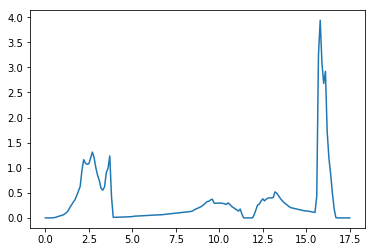

In [12]:
plt.plot(dos[0], dos[1])

In [13]:
cellinfo = get_cellinfo(atoms.cell)
cellinfo.special_points

{'G': array([0, 0, 0]),
 'K': array([0.375, 0.375, 0.75 ]),
 'L': array([0.5, 0.5, 0.5]),
 'U': array([0.625, 0.25 , 0.625]),
 'W': array([0.5 , 0.25, 0.75]),
 'X': array([0.5, 0. , 0.5])}

In [14]:
cellinfo.lattice

'fcc'

In [15]:
bands, labels = get_bands_and_labels(atoms)
labels

['$\\mathrm{\\mathsf{\\Gamma}}$',
 '$\\mathrm{\\mathsf{X}}$',
 '$\\mathrm{\\mathsf{W}}$',
 '$\\mathrm{\\mathsf{K}}$',
 '$\\mathrm{\\mathsf{\\Gamma}}$',
 '$\\mathrm{\\mathsf{L}}$',
 '$\\mathrm{\\mathsf{U}}$',
 '$\\mathrm{\\mathsf{W}}$',
 '$\\mathrm{\\mathsf{L}}$',
 '$\\mathrm{\\mathsf{K|U}}$',
 '$\\mathrm{\\mathsf{X}}$']

<module 'matplotlib.pyplot' from '/home/knoop/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

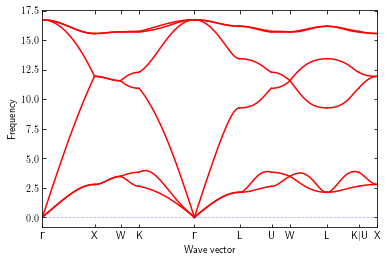

In [16]:
phonon.set_band_structure(bands)
phonon.plot_band_structure(labels=labels)

In [17]:
qp, dd, fr, ev, lab = ph.get_bandstructure(phonon)

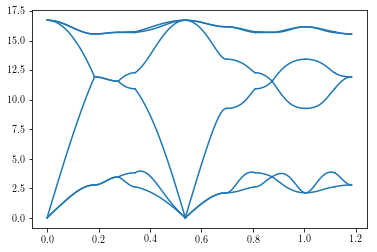

In [18]:
for d, f in zip(dd, fr):
    plt.plot(d, f, c='C0')